In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as nptype
import seaborn as sns
from scipy.stats import poisson

In [2]:
MAX_CARS = 20
MAX_MOVED_CARS = 5
AVG_RENTAL_REQUEST_LOC_1 = 3
AVG_RENTAL_REQUEST_LOC_2 = 4
AVG_RENTAL_RETURN_LOC_1 = 3
AVG_RENTAL_RETURN_LOC_2 = 2

RENTAL_CREDIT = 10
MOVE_CAR_COST = 2
PARK_COST = 4
RL_DISCOUNT = 0.9

# if k is greater than this => pmf = 0 i.e ignore
POISSON_UPPER_BOUND = 11
POISSON_PROBS = {
    lam: poisson.pmf(range(POISSON_UPPER_BOUND), lam)
    for lam in set(
        [
            AVG_RENTAL_REQUEST_LOC_1,
            AVG_RENTAL_REQUEST_LOC_2,
            AVG_RENTAL_RETURN_LOC_1,
            AVG_RENTAL_RETURN_LOC_2,
        ]
    )
}


def calc_expected_return(
    num_cars_per_loc: list[int],
    moved_cars: int,
    state_value: nptype.NDArray[np.float64],
    free_shuttle: bool,
    park_cost: bool,
    constant_returned_cars: bool,
):
    """
    moved_cars >= 0: move cars from 1st location to 2nd location, otherwise reverse the process
    """
    if num_cars_per_loc[0] < moved_cars or -moved_cars > num_cars_per_loc[1]:
        return -np.inf

    total_return = 0
    if free_shuttle and moved_cars > 0:
        total_return -= MOVE_CAR_COST * (moved_cars - 1)
    else:
        total_return -= MOVE_CAR_COST * abs(moved_cars)

    NUM_CARS_PER_LOC = np.minimum(
        [
            num_cars_per_loc[0] - moved_cars,
            num_cars_per_loc[1] + moved_cars,
        ],
        MAX_CARS,
    )

    for rental_request_loc_1 in range(POISSON_UPPER_BOUND):
        for rental_request_loc_2 in range(POISSON_UPPER_BOUND):
            joint_rent_prob = (
                POISSON_PROBS[AVG_RENTAL_REQUEST_LOC_1][rental_request_loc_1]
                * POISSON_PROBS[AVG_RENTAL_REQUEST_LOC_2][rental_request_loc_2]
            )

            num_of_cars_loc_1 = NUM_CARS_PER_LOC[0]
            num_of_cars_loc_2 = NUM_CARS_PER_LOC[1]

            possible_rental_cars_loc_1 = min(num_of_cars_loc_1, rental_request_loc_1)
            possible_rental_cars_loc_2 = min(num_of_cars_loc_2, rental_request_loc_2)

            reward = (
                possible_rental_cars_loc_1 + possible_rental_cars_loc_2
            ) * RENTAL_CREDIT
            if park_cost:
                if num_of_cars_loc_1 >= 10:
                    reward -= PARK_COST
                if num_of_cars_loc_2 >= 10:
                    reward -= PARK_COST
            num_of_cars_loc_1 -= possible_rental_cars_loc_1
            num_of_cars_loc_2 -= possible_rental_cars_loc_2

            if constant_returned_cars:
                returned_cars_loc_1 = AVG_RENTAL_RETURN_LOC_1
                returned_cars_loc_2 = AVG_RENTAL_RETURN_LOC_2
                num_of_cars_loc_1 = min(
                    num_of_cars_loc_1 + returned_cars_loc_1, MAX_CARS
                )
                num_of_cars_loc_2 = min(
                    num_of_cars_loc_2 + returned_cars_loc_2, MAX_CARS
                )
                total_return += joint_rent_prob * (
                    reward
                    + RL_DISCOUNT * state_value[num_of_cars_loc_1, num_of_cars_loc_2]
                )
            else:
                for returned_cars_loc_1 in range(POISSON_UPPER_BOUND):
                    for returned_cars_loc_2 in range(POISSON_UPPER_BOUND):
                        joint_return_prob = (
                            POISSON_PROBS[AVG_RENTAL_RETURN_LOC_1][returned_cars_loc_1]
                            * POISSON_PROBS[AVG_RENTAL_RETURN_LOC_2][returned_cars_loc_1]
                        )
                        num_of_cars_loc_1 = min(num_of_cars_loc_1 + returned_cars_loc_1, MAX_CARS)
                        num_of_cars_loc_2 = min(num_of_cars_loc_2 + returned_cars_loc_2, MAX_CARS)
                        joint_prob = joint_rent_prob * joint_return_prob
                        total_return += joint_prob * (
                            reward
                            + RL_DISCOUNT * state_value[num_of_cars_loc_1, num_of_cars_loc_2]
                        )

    return total_return


In [3]:
def policy_iteration(
    min_state_value_change: float = 1e-4,
    max_iterations: int = 4,
    free_shuttle=False,
    park_cost=False,
    constant_returned_cars=True,
):
    state_value = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
    policy = np.zeros(state_value.shape, dtype=int)
    actions = range(-MAX_MOVED_CARS, MAX_MOVED_CARS + 1)

    policy_histories = [policy.copy()]
    for iter in range(max_iterations):
        # Policy evaluation
        while True:
            old_state_value = state_value.copy()
            for i in range(MAX_CARS + 1):
                for j in range(MAX_CARS + 1):
                    state_value[i, j] = calc_expected_return(
                        num_cars_per_loc=[i, j],
                        moved_cars=policy[i, j],
                        state_value=state_value,
                        free_shuttle=free_shuttle,
                        park_cost=park_cost,
                        constant_returned_cars=constant_returned_cars,
                    )
            max_state_value_change = abs(old_state_value - state_value).max()
            # print("max value change {}".format(max_state_value_change))
            if max_state_value_change < min_state_value_change:
                break

        # Policy improvement
        policy_stable = True
        for i in range(MAX_CARS + 1):
            for j in range(MAX_CARS + 1):
                old_action = policy[i, j]
                action_returns = [
                    calc_expected_return(
                        num_cars_per_loc=[i, j],
                        moved_cars=action,
                        state_value=state_value,
                        free_shuttle=free_shuttle,
                        park_cost=park_cost,
                        constant_returned_cars=constant_returned_cars,
                    )
                    for action in actions
                ]
                new_action = actions[np.argmax(action_returns)]
                policy[i, j] = new_action
                if old_action != new_action:
                    policy_stable = False
        policy_histories.append(policy.copy())
        if policy_stable:
            break

    return policy_histories, state_value

In [4]:
def plot_heatmap(matrix_value, title: str, ax: plt.Axes):
    fig = sns.heatmap(np.flipud(matrix_value), cmap="YlGnBu", ax=ax)
    fig.set_ylabel("# cars at first location")
    fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
    fig.set_xlabel("# cars at second location")
    fig.set_title(title)

def plot_policy_iteration(policy_histories, state_value):
    cols = 3
    rows = np.ceil((len(policy_histories) + 1) / 3).astype(int)
    _, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    axes = axes.flatten()
    for (idx, policy) in enumerate(policy_histories):
        plot_heatmap(policy, f"policy {idx}", axes[idx])
    plot_heatmap(state_value, f"optimal value", axes[-1])
    plt.show()

In [5]:
policy_histories, state_value = policy_iteration(max_iterations=4)

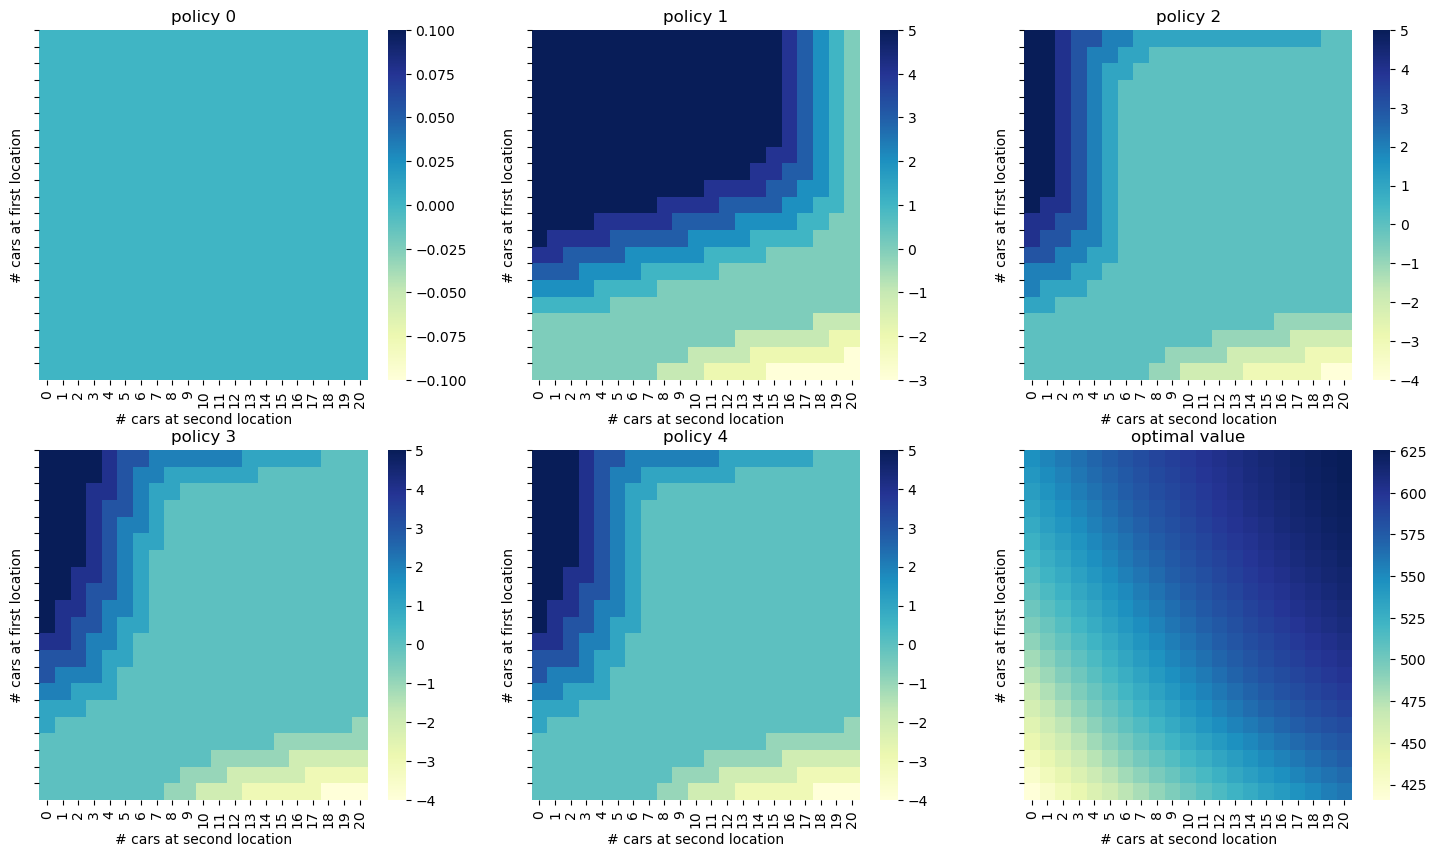

In [6]:
plot_policy_iteration(policy_histories, state_value)

In [7]:
policy_histories, state_value = policy_iteration(max_iterations=4, free_shuttle=True, park_cost=True)

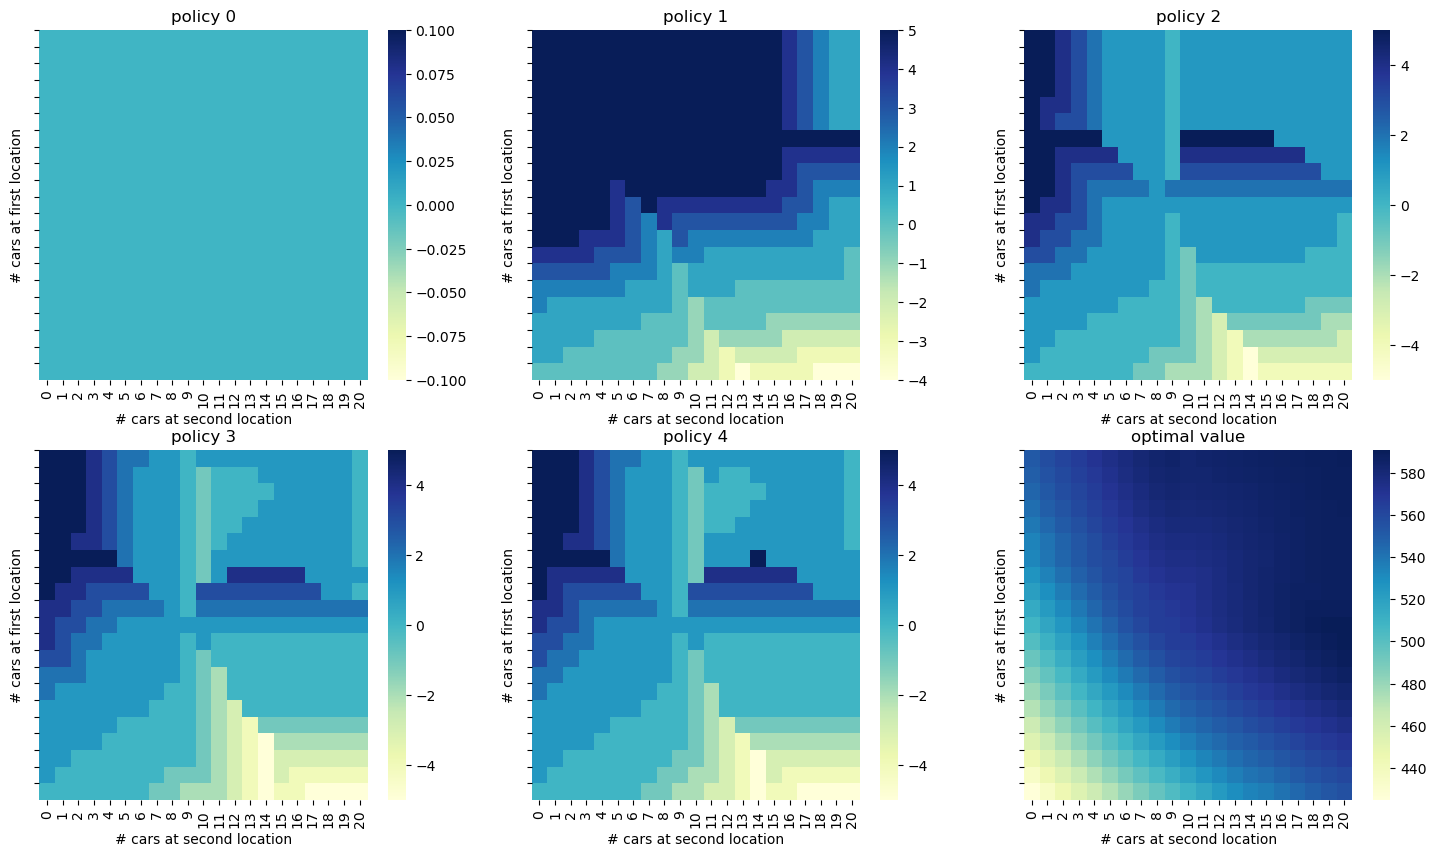

In [8]:
plot_policy_iteration(policy_histories, state_value)